In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# 自定义数据集类：要求数据集目录下每个子文件夹为一个类别
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(cls_path, img_name)
                    images.append((img_path, self.class_to_idx[cls]))
        print(f"共加载 {len(images)} 张图片，共 {len(self.classes)} 个类别。")
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"加载图片 {img_path} 出错: {e}")
        if self.transform:
            image = self.transform(image)
        return image, label

# 定义更深的 CNN 模型（DeepCNN）
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 224x224 -> 112x112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2: 112x112 -> 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3: 56x56 -> 28x28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 4: 28x28 -> 14x14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 5: 14x14 -> 7x7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 使用全局平均池化降低参数量
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train():
    # 检查 GPU 可用性
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")

    # 数据预处理：调整图片大小为 224x224，并进行归一化
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
       
    ])

    # 创建数据集（请确保该路径下有 3 个类别的子文件夹）
    dataset = EnhancedDataset(root_dir=r"L:\常惠林\萎凋\自然萎凋\分类", transform=transform)

    # 按 6:2:2 划分数据集为训练、验证、测试集
    total_num = len(dataset)
    train_size = int(0.6 * total_num)
    val_size = int(0.2 * total_num)
    test_size = total_num - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"训练集：{train_size}，验证集：{val_size}，测试集：{test_size}")

    # 数据加载器设置
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

    # 初始化模型，使用更深的 CNN 模型 DeepCNN
    model = DeepCNN(num_classes=len(dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)

        # 验证阶段
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # 保存验证集准确率最高的模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_deepcnn_model.pth")
            print("保存最佳模型！")

    # 测试阶段
    model.load_state_dict(torch.load("best_deepcnn_model.pth"))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

if __name__ == "__main__":
    train()


使用设备：cuda
共加载 5616 张图片，共 3 个类别。
训练集：3369，验证集：1123，测试集：1124
Epoch [1/100], Loss: 0.8908, Val Acc: 42.39%
保存最佳模型！
Epoch [2/100], Loss: 0.7957, Val Acc: 41.05%
Epoch [3/100], Loss: 0.7621, Val Acc: 61.62%
保存最佳模型！
Epoch [4/100], Loss: 0.7436, Val Acc: 40.78%
Epoch [5/100], Loss: 0.7240, Val Acc: 51.91%
Epoch [6/100], Loss: 0.7027, Val Acc: 48.89%
Epoch [7/100], Loss: 0.6807, Val Acc: 56.90%
Epoch [8/100], Loss: 0.6729, Val Acc: 40.25%
Epoch [9/100], Loss: 0.6640, Val Acc: 63.05%
保存最佳模型！
Epoch [10/100], Loss: 0.6468, Val Acc: 42.12%
Epoch [11/100], Loss: 0.6248, Val Acc: 61.89%
Epoch [12/100], Loss: 0.6345, Val Acc: 39.54%
Epoch [13/100], Loss: 0.6010, Val Acc: 35.62%
Epoch [14/100], Loss: 0.5946, Val Acc: 51.29%
Epoch [15/100], Loss: 0.5831, Val Acc: 70.79%
保存最佳模型！
Epoch [16/100], Loss: 0.5664, Val Acc: 51.11%
Epoch [17/100], Loss: 0.5565, Val Acc: 50.67%
Epoch [18/100], Loss: 0.5603, Val Acc: 53.43%
Epoch [19/100], Loss: 0.5402, Val Acc: 69.90%
Epoch [20/100], Loss: 0.5458, Val Acc: 64.74

C:\Users\enine\AppData\Local\Temp\ipykernel_15764\2812120522.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deepcnn_model.pth")

Test Accuracy: 82.83%


使用设备：cuda
共加载 5616 张图片，共 3 个类别。
训练集：3369，验证集：1123，测试集：1124
Epoch [1/100] | Train Loss: 0.9099 | Train Acc: 0.5444 | Val Loss: 6.7061 | Val Acc: 0.4132
保存最佳模型！
Epoch [2/100] | Train Loss: 0.8308 | Train Acc: 0.5984 | Val Loss: 0.9775 | Val Acc: 0.4942
保存最佳模型！
Epoch [3/100] | Train Loss: 0.7968 | Train Acc: 0.6097 | Val Loss: 2.9965 | Val Acc: 0.4105
Epoch [4/100] | Train Loss: 0.7659 | Train Acc: 0.6379 | Val Loss: 1.2734 | Val Acc: 0.4310
Epoch [5/100] | Train Loss: 0.7349 | Train Acc: 0.6515 | Val Loss: 0.9077 | Val Acc: 0.5628
保存最佳模型！
Epoch [6/100] | Train Loss: 0.7103 | Train Acc: 0.6542 | Val Loss: 1.4984 | Val Acc: 0.5414
Epoch [7/100] | Train Loss: 0.7077 | Train Acc: 0.6465 | Val Loss: 0.7757 | Val Acc: 0.6269
保存最佳模型！
Epoch [8/100] | Train Loss: 0.6974 | Train Acc: 0.6604 | Val Loss: 2.4661 | Val Acc: 0.2965
Epoch [9/100] | Train Loss: 0.6889 | Train Acc: 0.6726 | Val Loss: 1.1995 | Val Acc: 0.5156
Epoch [10/100] | Train Loss: 0.6868 | Train Acc: 0.6806 | Val Loss: 0.7925 | Val 

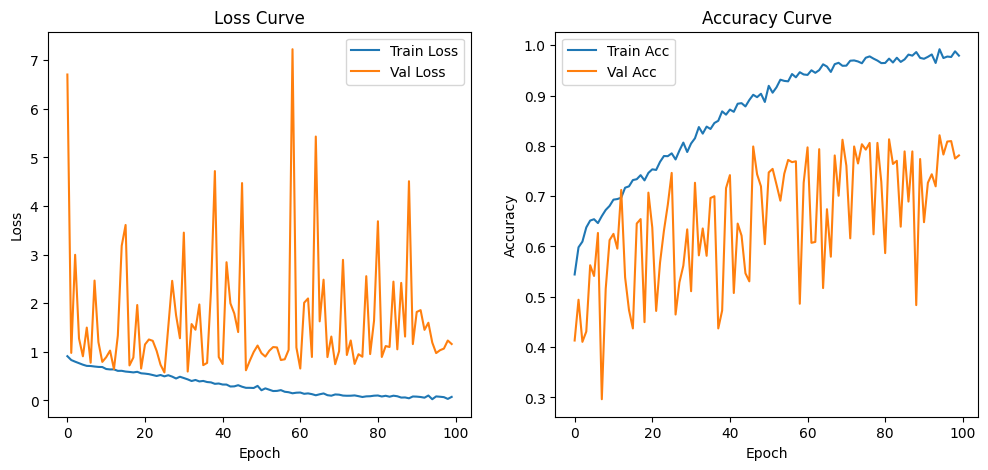

C:\Users\enine\AppData\Local\Temp\ipykernel_9688\4116969863.py:218: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deepcnn_model.pth", 

Test Accuracy: 80.52%
混淆矩阵：
[[352  83   2]
 [ 45 270  25]
 [  1  63 283]]


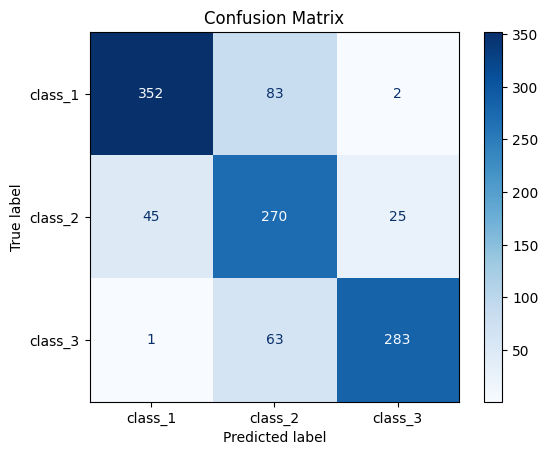

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 自定义数据集类：要求数据集目录下每个子文件夹为一个类别
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(cls_path, img_name)
                    images.append((img_path, self.class_to_idx[cls]))
        print(f"共加载 {len(images)} 张图片，共 {len(self.classes)} 个类别。")
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"加载图片 {img_path} 出错: {e}")
        if self.transform:
            image = self.transform(image)
        return image, label

# 定义更深的 CNN 模型（DeepCNN）
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1: 224x224 -> 112x112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2: 112x112 -> 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3: 56x56 -> 28x28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 4: 28x28 -> 14x14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 5: 14x14 -> 7x7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 使用全局平均池化降低参数量
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train():
    # 检查 GPU 可用性
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")

    # 数据预处理：调整图片大小为 224x224，并进行归一化
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # 创建数据集（请确保该路径下有 3 个类别的子文件夹）
    dataset = EnhancedDataset(root_dir=r"L:\常惠林\萎凋\自然萎凋\分类", transform=transform)
    total_num = len(dataset)
    train_size = int(0.6 * total_num)
    val_size = int(0.2 * total_num)
    test_size = total_num - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"训练集：{train_size}，验证集：{val_size}，测试集：{test_size}")

    # 数据加载器设置（batch size 设为 32）
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

    # 初始化模型，使用更深的 CNN 模型 DeepCNN
    model = DeepCNN(num_classes=len(dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    best_val_acc = 0.0

    # 用于记录训练和验证过程指标的列表
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total_train += labels.size(0)
        epoch_loss = running_loss / total_train
        epoch_acc = running_correct / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = val_running_loss / total_val
        val_acc = val_running_correct / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

       
        save_dir = r"L:\常惠林\code\result"
        os.makedirs(save_dir, exist_ok=True)  # 如果目录不存在，则创建目录

        # 保存验证集上表现最好的模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # 拼接保存路径
            save_path = os.path.join(save_dir, "best_resnet50.pth")
            torch.save(model.state_dict(), save_path)
            print(f"保存最佳模型到: {save_path}")

    # 绘制训练/验证曲线
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

    # 测试阶段：加载最佳模型后进行测试，并计算混淆矩阵
    model.load_state_dict(torch.load("best_deepcnn_model.pth", map_location=device))
    model.eval()
    test_correct = 0
    total_test = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            total_test += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = 100 * test_correct / total_test
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 计算混淆矩阵并显示
    cm = confusion_matrix(all_labels, all_preds)
    print("混淆矩阵：")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    train()
